Source of original dataset: https://www.sciencedirect.com/science/article/pii/S2352340918315191

# Overview

The dataset is a subset of hotel demand data from two hotel, one resort and one urban hotel. There are ~36k reservations and 17 variables, including whether the person cancel their reservation, which will be used as the target (binary) variable. The reservations are associated with arrival dates between July 1, 2015 and August 31, 2017.

In [ ]:
# !pip install kaggle
# !pip install xgboost

In [1]:
import os
from dotenv import load_dotenv
import tempfile
import urllib
import zipfile
import re


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder, MeanEncoder
from feature_engine.transformation import YeoJohnsonTransformer, LogCpTransformer




In [2]:
# must load prior to import
load_dotenv()
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate
api = KaggleApi()
api.authenticate()

# UDF

In [3]:
def to_snake_case(name: str) -> str:
    # Preserve existing underscores and replace spaces or special characters with underscores
    name = re.sub(r'[^\w\s]', '', name)  # Remove special characters except underscores
    name = re.sub(r'(?<=[a-z])(?=[A-Z])', '_', name)  # Handle camelCase to snake_case
    name = re.sub(r'[\s]+', '_', name)  # Replace spaces with underscores
    return name.lower()

def convert_columns_to_snake_case(df: pd.DataFrame) -> pd.DataFrame:
    # Transform column names
    new_columns = [to_snake_case(col).replace('__', '_') for col in df.columns]
    df.columns = new_columns
    return df

def plot_null_val_heatmap(df, plot_title, figsize):    
    plt.figure(figsize=figsize)
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title(plot_title, fontsize=16, fontweight='bold')
    plt.tight_layout();
    

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# "GLOBAL" VARIABLES

In [4]:
VARIABLE_RENAME_MAP = {
    "repeated" : "is_repeat_guest",
    "pc": "num_previous_cancellations",
    "pnot_c": "num_previous_bookings_not_canceled",
}

MONTH_ABBREVIATION_MAP = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}


MONTH_ORDER = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

DAY_OF_WEEK_ORDER = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

BOOKING_MAP = {
    "Not_Canceled": 0,
    "Canceled": 1,
}

# Data Import & Processing

In [5]:
# Download the Kaggle dataset to a temporary directory, then read CSV files 
dataset_name = "youssefaboelwafa/hotel-booking-cancellation-prediction"

with tempfile.TemporaryDirectory() as temp_dir:
    print(f"Temporary directory created at : {temp_dir}")
    
    
    zip_file_path = os.path.join(temp_dir, f"{dataset_name.split('/')[-1]}.zip")
    api.dataset_download_files(dataset_name, path=temp_dir, unzip=False)
    
    # Unzip the downloaded file
    extracted_dir = os.path.join(temp_dir, "extracted")
    os.makedirs(extracted_dir, exist_ok=True)
    
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extracted_dir)
    print(f"Dataset extracted to {extracted_dir}")
    
    # List and read the extracted files
    extracted_files = os.listdir(extracted_dir)
    print(f"Extracted files: {extracted_files}")
    
    
    # Read an concatenate CSV files
    extracted_files = os.listdir(extracted_dir)
    
    csv_files = [os.path.join(extracted_dir, file) for file in extracted_files if file.endswith(".csv")]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the extracted dataset.")
    
    # Created master dataframe
    dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]
    data = pd.concat(dataframes, ignore_index=True)

    # Preview the master dataframe
    print("Master DataFrame preview:")
    print(data.head())
    
    
print("Temporary directory cleaned up.")

Temporary directory created at : /var/folders/3v/y95lp0yj79gd9p1xmw9wg0yw0000gn/T/tmpy1fu51sx
Dataset URL: https://www.kaggle.com/datasets/youssefaboelwafa/hotel-booking-cancellation-prediction
Dataset extracted to /var/folders/3v/y95lp0yj79gd9p1xmw9wg0yw0000gn/T/tmpy1fu51sx/extracted
Extracted files: ['booking.csv']
Master DataFrame preview:
  Booking_ID  number of adults  number of children  number of weekend nights  \
0   INN00001                 1                   1                         2   
1   INN00002                 1                   0                         1   
2   INN00003                 2                   1                         1   
3   INN00004                 1                   0                         0   
4   INN00005                 1                   0                         1   

   number of week nights  type of meal  car parking space    room type  \
0                      5   Meal Plan 1                  0  Room_Type 1   
1                      3  

In [6]:
# Formate column names
data = convert_columns_to_snake_case(data)

# Make column names more intuitive
data = data.rename(columns=VARIABLE_RENAME_MAP)

In [7]:
data.head()

,booking_id,number_of_adults,number_of_children,number_of_weekend_nights,number_of_week_nights,type_of_meal,car_parking_space,room_type,lead_time,market_segment_type,is_repeat_guest,num_previous_cancellations,num_previous_bookings_not_canceled,average_price,special_requests,date_of_reservation,booking_status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [10]:
# params
random_state = 3
test_size = 0.2
shuffle = True

# Create test dataset. Do not engineering new features for test set.
X = data.drop("booking_status", axis=1)
y = data["booking_status"].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size, shuffle=shuffle)


## Extract date information training & validation sets

The `date_of_reservation` variable is not inherently informative for our model, as specific calendar dates do not repeat in a meaningful way. However, extracting the **month** and **day of the week** from the reservation date can provide useful patterns for prediction.

#### Steps:
1. Extract the following features from `date_of_reservation`:
   - `month_of_reservation`: The month (e.g., January, February) of the reservation.
   - `day_of_week`: The day of the week (e.g., Monday, Tuesday) of the reservation.

2. Drop the original `date_of_reservation` column from the dataset.

#### Important Note:
We will only process the **training** and **validation** sets at this stage. The test set remains unprocessed to ensure it is unseen and unaltered until the final evaluation of our predictive model.

In [12]:
# Extract more granular time series from date_of_reservation
# Use coerce b/c 2/29/2018 is in the dataset, but 2018 wasn't a leap year
X_train["date_of_reservation"] = pd.to_datetime(X_train["date_of_reservation"], format='%m/%d/%Y', errors='coerce').dt.date 
X_train["month_of_reservation"] = pd.to_datetime(X_train["date_of_reservation"], errors="coerce").dt.month
# X_train["season_of_reservation"] = X_train["month_of_reservation"].map(month_to_season)
X_train["month_of_reservation"] = X_train["month_of_reservation"].map(MONTH_ABBREVIATION_MAP)
X_train["day_of_week"] = pd.to_datetime(X_train["date_of_reservation"]).dt.day_name()
# X_train["is_weekend"] = np.where(
#     X_train["day_of_week"].isna(), # Check if day_of_week is NaN
#     np.nan, # Assign NaN if true
#     X_train["day_of_week"].isin(["Saturday", "Sunday"]).astype("object") # Compute is_weekened otherwise
# )

X_train.drop(labels="date_of_reservation", axis=1, inplace=True)


# Create binary predictor
y_train = pd.DataFrame(y_train, columns=["booking_status"])
y_train["is_cancellation"] = y_train["booking_status"].map(BOOKING_MAP)
y_train = y_train["is_cancellation"].copy()

In [13]:
# Create validation set from training set

# params are from initial train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=random_state, test_size=test_size, shuffle=shuffle)

In [14]:
print("Train: ", X_train.shape)
print("Validation: ", X_val.shape)
print("Test: ", X_test.shape)

Train:  (23222, 17)
Validation:  (5806, 17)
Test:  (7257, 16)


In [15]:
# Concatenate all dependent and independent variables for each dataset to save them for future use
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


# Save datasets
data_directory = "data"

df_train.to_csv(f"{data_directory}/train.csv", header=True, index=False)
df_val.to_csv(f"{data_directory}/validation.csv", header=True, index=False)
df_test.to_csv(f"{data_directory}/test.csv", header=True, index=False)

# EDA on Training Setting

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23222 entries, 3104 to 23607
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   booking_id                          23222 non-null  object 
 1   number_of_adults                    23222 non-null  int64  
 2   number_of_children                  23222 non-null  int64  
 3   number_of_weekend_nights            23222 non-null  int64  
 4   number_of_week_nights               23222 non-null  int64  
 5   type_of_meal                        23222 non-null  object 
 6   car_parking_space                   23222 non-null  int64  
 7   room_type                           23222 non-null  object 
 8   lead_time                           23222 non-null  int64  
 9   market_segment_type                 23222 non-null  object 
 10  is_repeat_guest                     23222 non-null  int64  
 11  num_previous_cancellations          23222 n

In [17]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
number_of_adults,23222.0,1.845018,0.518601,0.0,2.0,2.00,2.00,4.0
number_of_children,23222.0,0.104771,0.398853,0.0,0.0,0.00,0.00,9.0
number_of_weekend_nights,23222.0,0.807855,0.868481,0.0,0.0,1.00,2.00,7.0
number_of_week_nights,23222.0,2.197356,1.402787,0.0,1.0,2.00,3.00,17.0
car_parking_space,23222.0,0.030704,0.172517,0.0,0.0,0.00,0.00,1.0
lead_time,23222.0,85.670485,86.281294,0.0,17.0,58.00,127.75,443.0
is_repeat_guest,23222.0,0.026096,0.159424,0.0,0.0,0.00,0.00,1.0
num_previous_cancellations,23222.0,0.024373,0.386244,0.0,0.0,0.00,0.00,13.0
num_previous_bookings_not_canceled,23222.0,0.161743,1.830326,0.0,0.0,0.00,0.00,58.0
average_price,23222.0,103.470801,35.211322,0.0,80.3,99.45,120.00,540.0


### Categorical Features

In [18]:
categorical_features = df_train.select_dtypes(include=["object", "category"])
categorical_features.head(10)

,booking_id,type_of_meal,room_type,market_segment_type,month_of_reservation,day_of_week
3104,INN03105,Meal Plan 1,Room_Type 1,Online,Nov,Monday
35123,INN35124,Not Selected,Room_Type 1,Online,Dec,Monday
7177,INN07178,Meal Plan 1,Room_Type 1,Online,Jun,Sunday
3869,INN03870,Meal Plan 1,Room_Type 1,Offline,Jan,Friday
16383,INN16384,Not Selected,Room_Type 1,Offline,Dec,Monday
12826,INN12827,Meal Plan 1,Room_Type 1,Corporate,Sep,Wednesday
25523,INN25524,Meal Plan 1,Room_Type 1,Offline,Oct,Monday
25454,INN25455,Meal Plan 1,Room_Type 2,Online,Jul,Sunday
28953,INN28954,Meal Plan 1,Room_Type 1,Offline,Jul,Friday
15071,INN15072,Meal Plan 1,Room_Type 1,Offline,Jul,Thursday


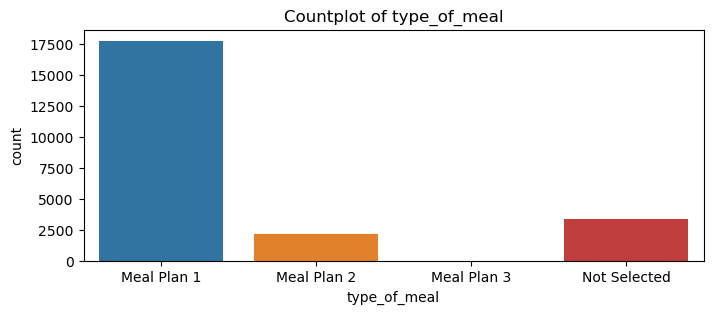

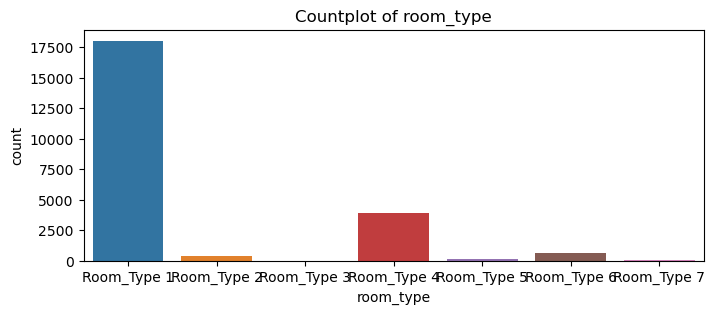

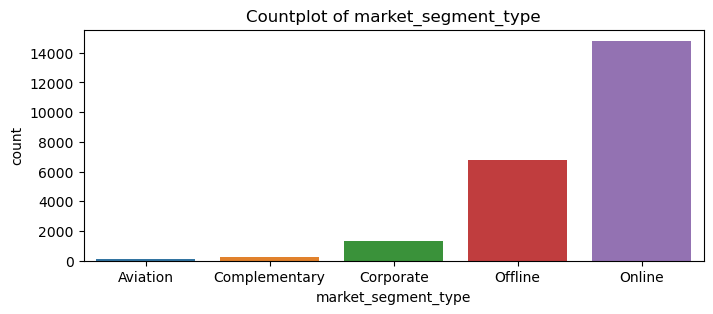

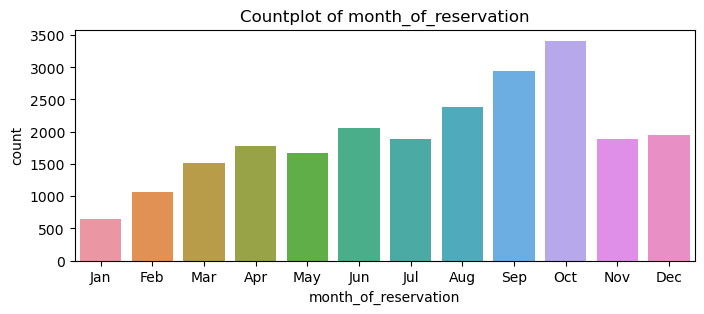

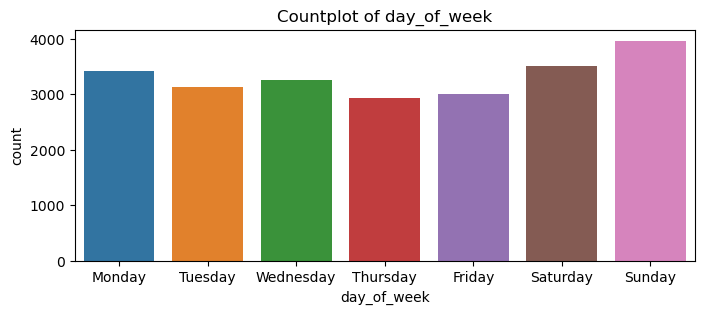

In [19]:
for feature in categorical_features.columns:
    if feature not in ["booking_id", "date_of_reservation"]:
        plt.figure(figsize=(8, 3))
        
        # Check if the feature is "month_to_reservation" and use custom order
        if feature == "month_of_reservation":
            sns.countplot(x=feature, data=df_train, order=MONTH_ORDER)
        elif feature == "day_of_week":
            sns.countplot(x=feature, data=df_train, order=DAY_OF_WEEK_ORDER)
        else:
            unique_values = df_train[feature].dropna().unique()
            sns.countplot(x=feature, data=df_train, order=sorted(unique_values))
        
        plt.title(f"Countplot of {feature}")
        plt.show()

### Numerical Features

In [20]:
numerical_features = df_train.select_dtypes(exclude=["object"])

numerical_features.head(10)

,number_of_adults,number_of_children,number_of_weekend_nights,number_of_week_nights,car_parking_space,lead_time,is_repeat_guest,num_previous_cancellations,num_previous_bookings_not_canceled,average_price,special_requests,is_cancellation
3104,1,0,0,2,0,32,0,0,0,0.00,0,0
35123,2,0,2,3,0,90,0,0,0,74.80,1,0
7177,2,0,1,2,0,121,0,0,0,90.00,0,1
3869,1,0,0,3,0,151,0,0,0,80.00,0,0
16383,2,0,2,1,0,31,0,0,0,63.00,0,0
12826,1,0,2,0,0,0,1,1,2,65.00,0,0
25523,1,0,0,2,0,164,0,0,0,100.00,0,0
25454,0,2,0,1,0,193,0,0,0,86.50,0,1
28953,2,0,1,4,0,142,0,0,0,72.25,2,0
15071,2,0,1,0,0,96,0,0,0,63.75,0,0


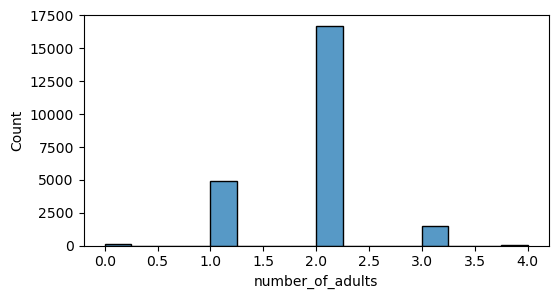

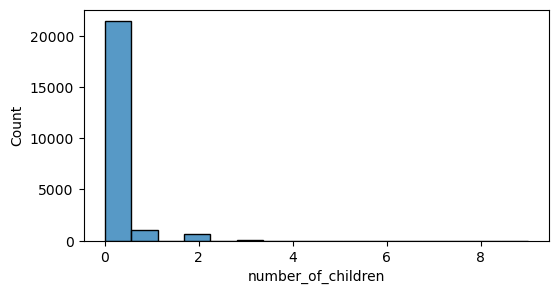

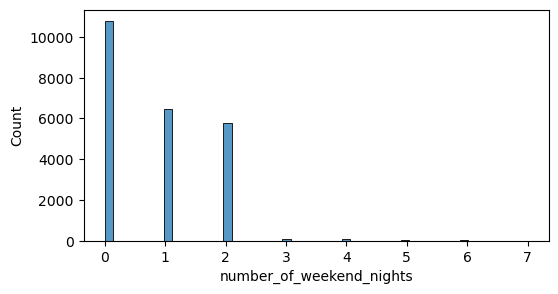

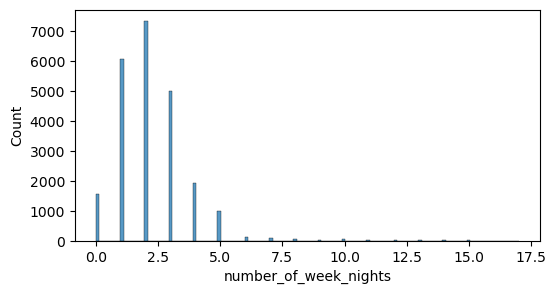

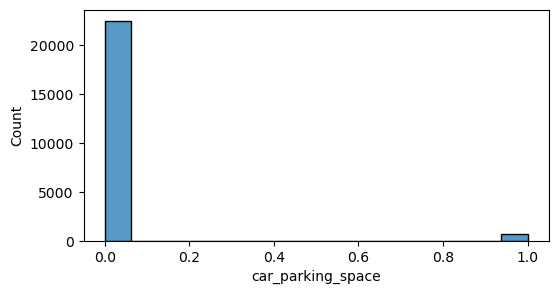

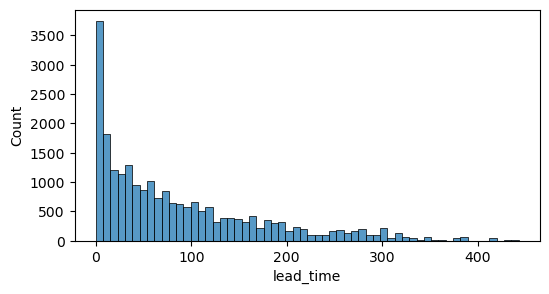

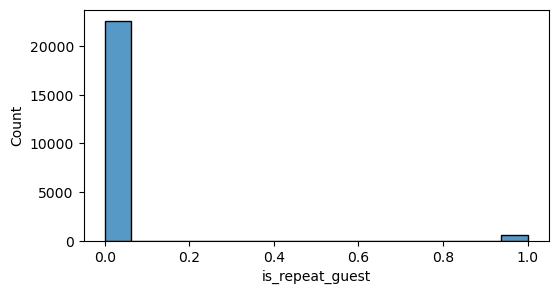

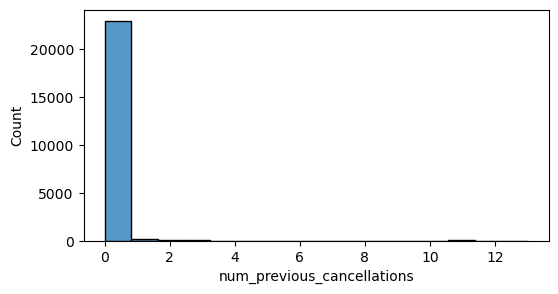

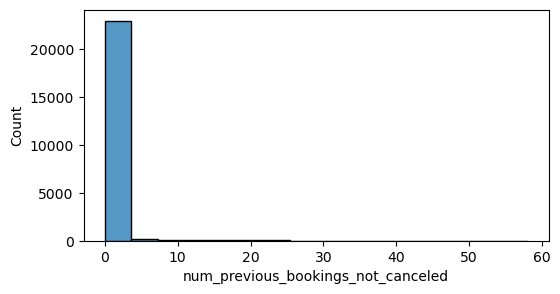

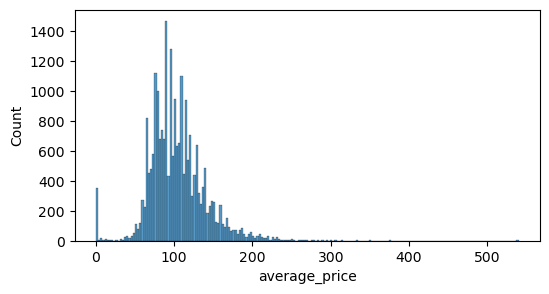

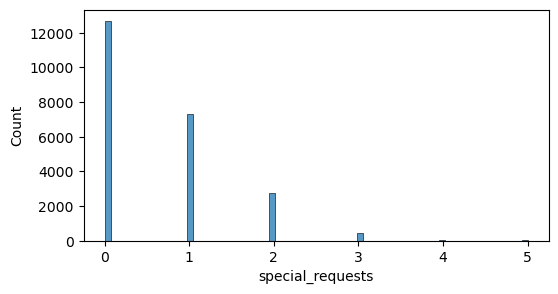

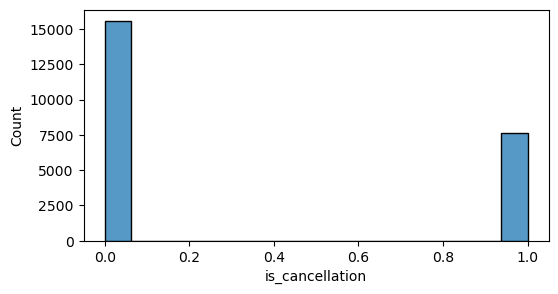

In [21]:
for feature in numerical_features.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(df_train[feature])
    plt.show()

### Observation:

The target variable, `is_cancellation`, is reasonably balanced in the training set. Specifically:
- **33% of `is_cancellation` values are positive (`1`)**, indicating that approximately one-third of the reservations result in cancellations.

In [25]:
df_train["is_cancellation"].sum() / df_train.shape[0]

0.32822323658599606

### Target Variable vs Numerical Variable

We will use box and violin plots to visualize the numerical variables's distributions by class. This helps to achieve:

1. **Identify Class Separation**: Understand how well the feature differentiates between classes.
2. **Detect Outliers**: Spot class-specific anomalies for data cleaning.
3. **Understand Relationships**: Reveal patterns that guide feature selection or transformations.
4. **Engineer New Features**: Identify opportunities for scaling, binning, or transformations.
5. **Validate Domain Knowledge**: Compare distributions against domain expectations to spot data issues.


These insights improve feature understanding and, may be used to, enhance model performance.

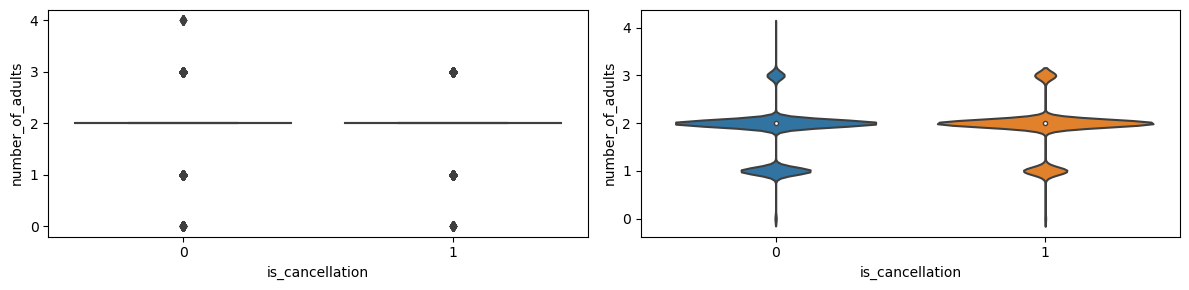

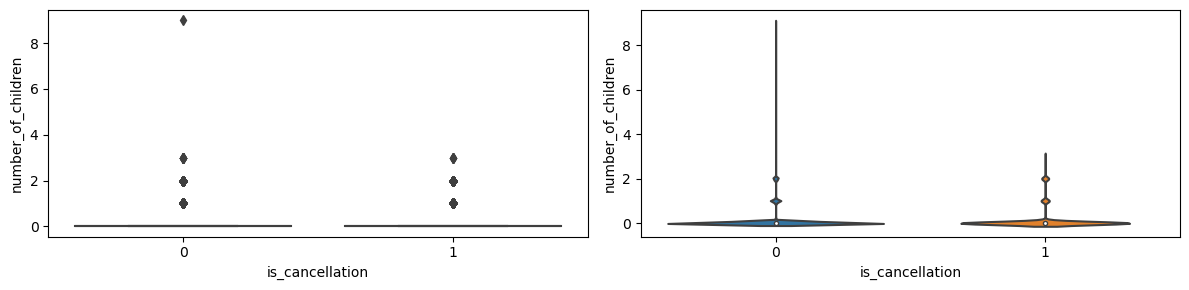

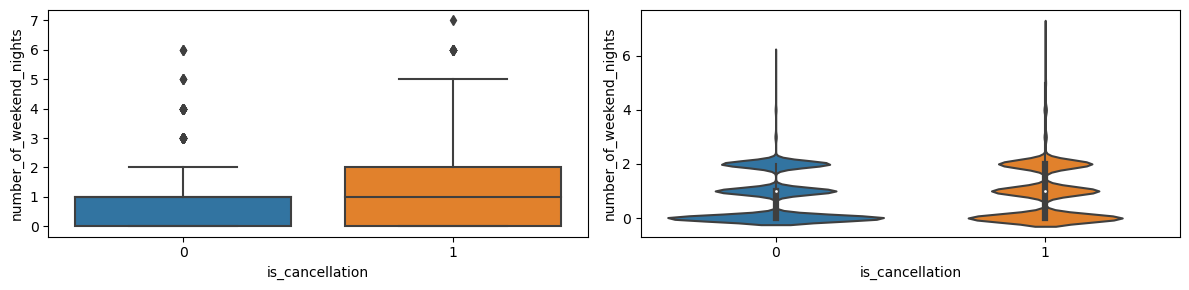

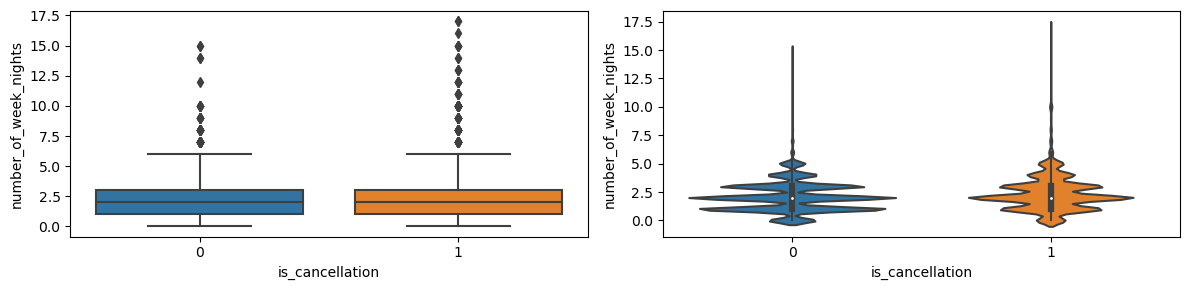

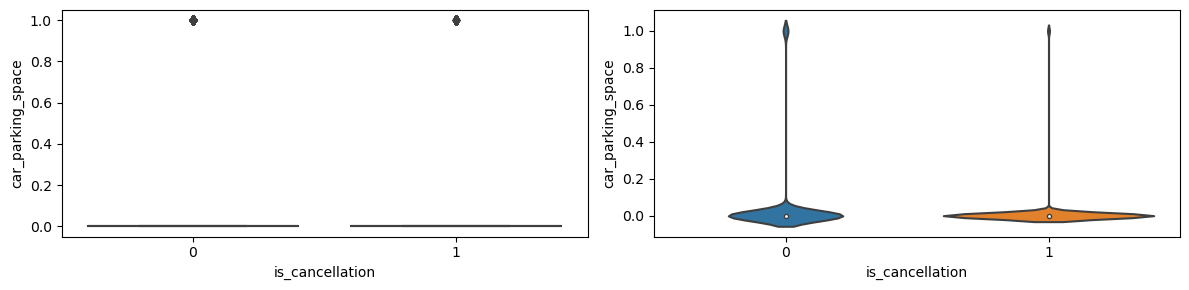

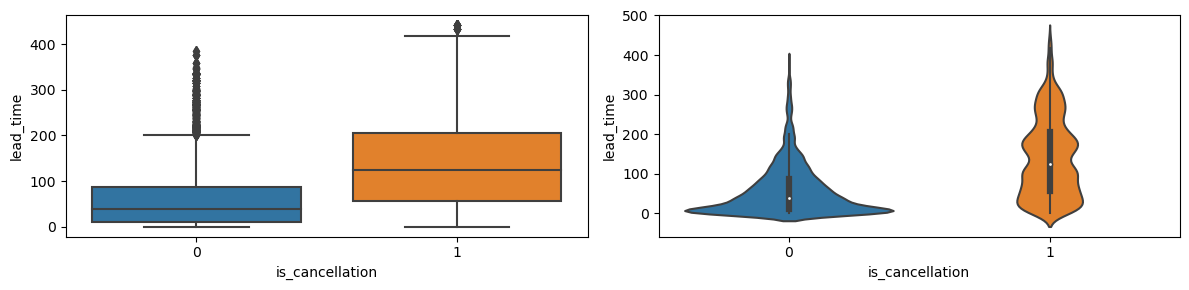

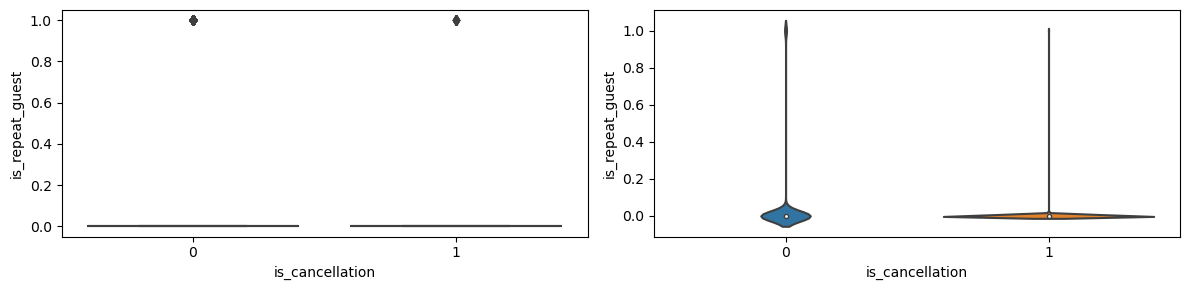

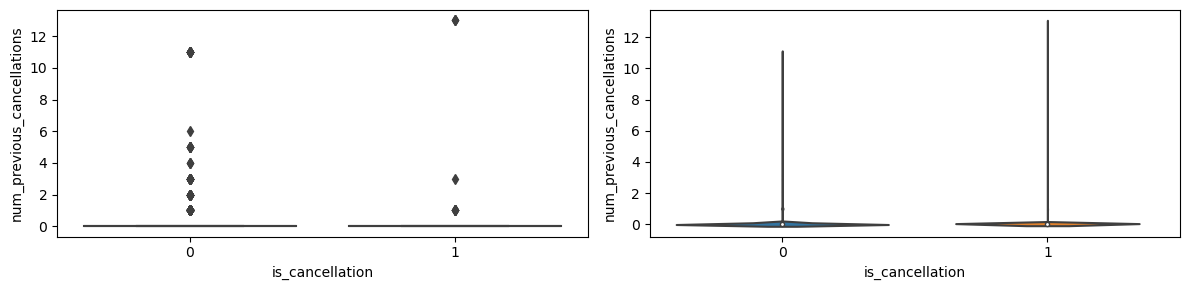

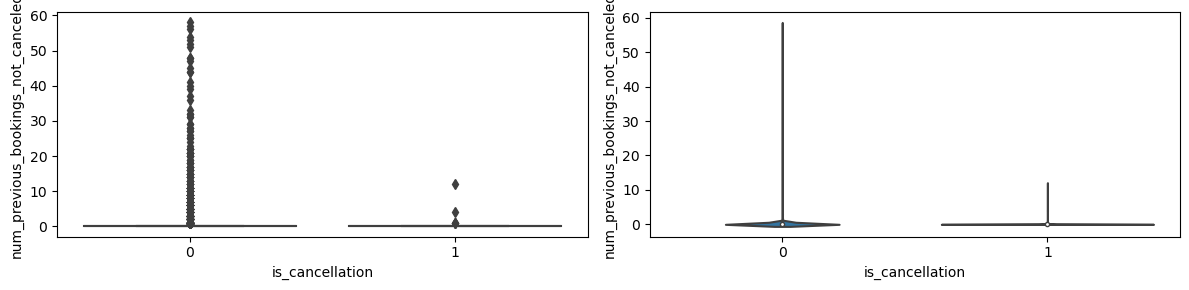

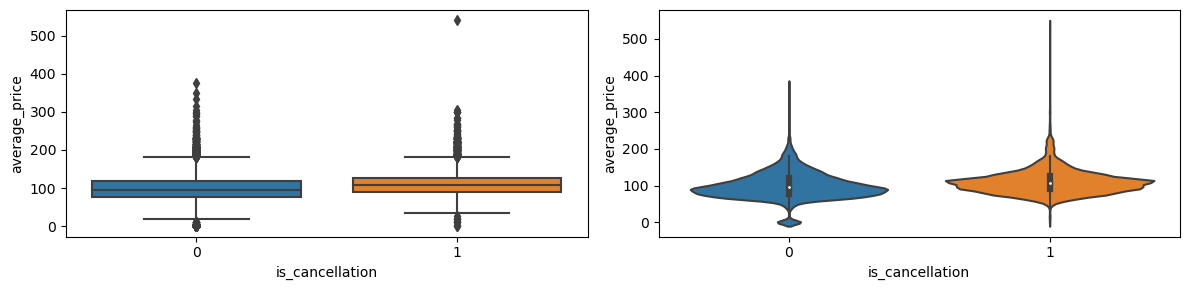

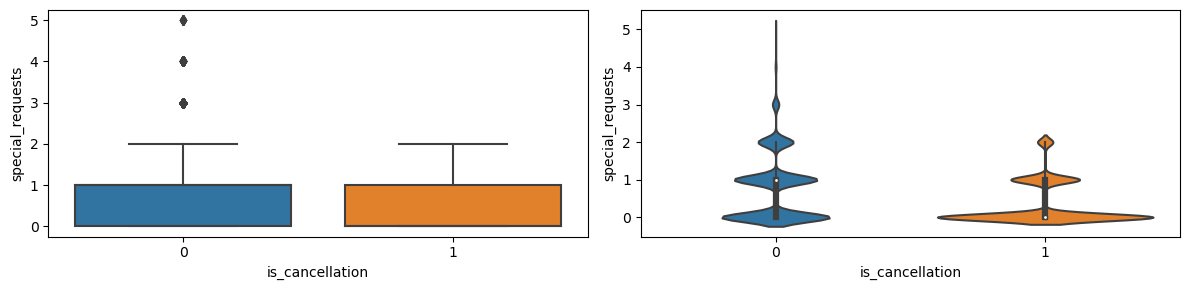

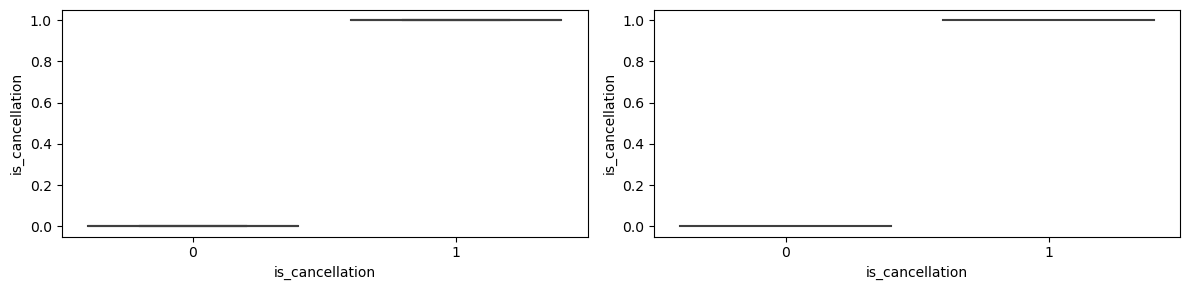

In [22]:
for feature in numerical_features.columns:
    plt.figure(figsize=(12, 3))
    
    # boxplot subplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_train, x="is_cancellation", y=feature)
    
    # violin plot subplot
    plt.subplot(1, 2, 2)
    sns.violinplot(data=df_train, x="is_cancellation", y=feature)
    
    plt.tight_layout()
    plt.show()

### Oberservations:

- `number_of_adults`: The data does not reveal any discernible patterns, as the distributions for `Not_Canceled` and `Canceled` are quite similar.

- `number_of_children`: Similar to `number_of_adults`, the distributions for `Not_Canceled` and `Canceled` are nearly identical.

- `number_of_weekend_nights`: An interesting insight emerges here. Guests who do **not** reserve rooms during the weekend are less likely to cancel their reservations.

- `number_of_week_nights`: The data shows no significant difference in distribution between `Not_Canceled` and `Canceled`.

- `car_parking_space`: Like several other features, this does not show a noticeable pattern, as the two distributions are almost identical.

- `lead_time`: The data suggests that the longer in advance a reservation is made, the higher the likelihood of cancellation.

- `is_repeat_guest`: There is no significant difference observed between the two distributions for this feature.

- `num_previous_cancellations`: Surprisingly, there isn’t much difference in the distributions for `Not_Canceled` and `Canceled`. However, this warrants further investigation, as historical cancellations could provide valuable predictive insights.

- `num_previous_bookings_no_cancellation`: This feature indicates that a history of reservations without cancellations correlates with a higher probability of not canceling future reservations.

- `average_price`: The data might suggest a positive correlation between higher prices and the likelihood of cancellation. Further analysis is needed to confirm this.

- `special_requests`: While the distributions for `Not_Canceled` and `Canceled` are similar, there could be a positive correlation between the number of special requests and the likelihood of not canceling a reservation.




# Target Variable vs Categorical Variables

Calculating the mean of a binary target variable for each category of a categorical feature is a valuable approach for measuring the correlation or association between the categorical variable and the target.

For a binary target variable, the mean value of the target for each category represents the probability of the positive class (`1`) for that category. Categories with **higher mean target values are more likely to correspond to the positive class**, indicating a stronger relationship with the target. This method serves as an effective preliminary feature analysis, helping to evaluate whether a categorical variable may be predictive of the target.

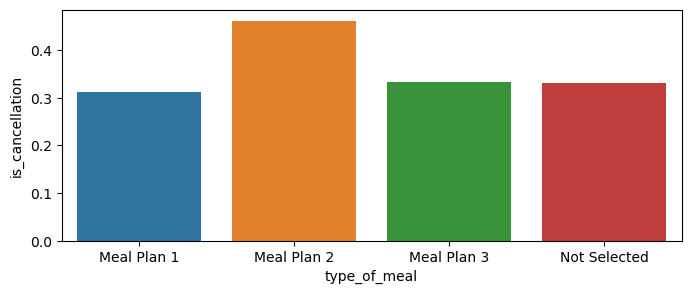

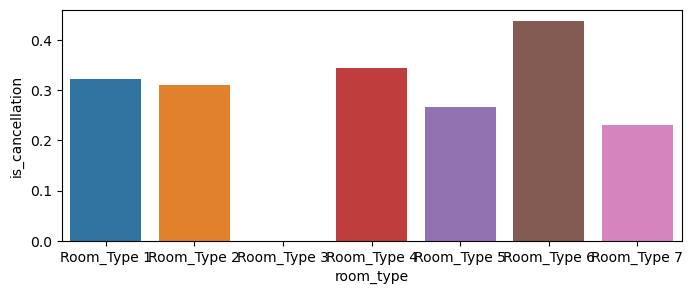

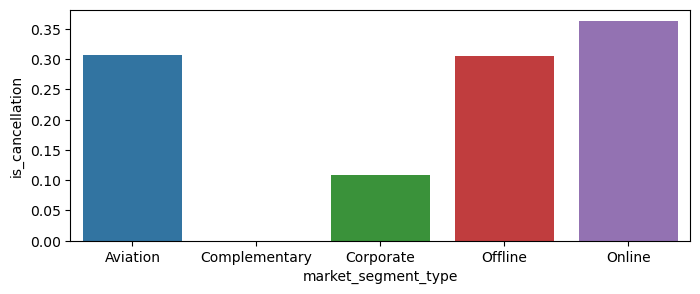

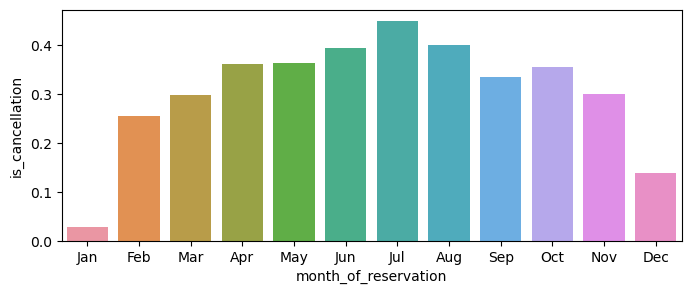

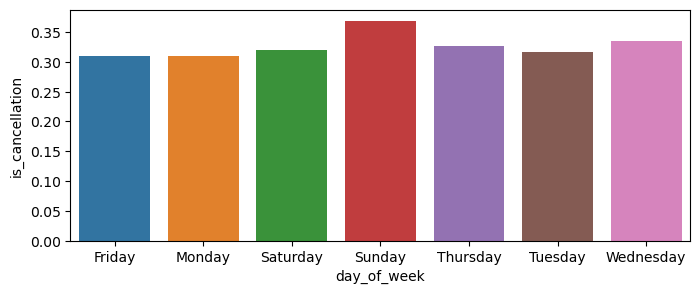

In [28]:
for feature in categorical_features:
    if feature not in ["booking_id", "date_of_reservation", "booking_status"]:
        plt.figure(figsize=(8,3))
        category_means = df_train.groupby(feature)["is_cancellation"].mean().reset_index()
        
        if feature == "month_of_reservation":
            sns.barplot(data=category_means, x=feature, y="is_cancellation", order=MONTH_ORDER)
        else:
            sns.barplot(data=category_means, x=feature, y="is_cancellation")
        
        plt.show()

### Observations:

- `type_of_meal`: The data indicates that guests who selected meal plan #2 may have a higher tendency to cancel their reservations compared to other meal plans.

- `room_type`: The countplot analysis reveals a notable imbalance across room types. While most reservations are for room types 1 and 4, other room types have significantly lower frequencies. Interestingly, reservations for room type 3 appear to have a lower cancellation tendency, whereas room type 4 exhibits a higher likelihood of cancellation.

- `market_segment_type`: Guests who receive complimentary rooms or travel for work are less likely to cancel their reservations compared to individuals in other market segments.

- `month_of_reservation`: Reservations made for December and January exhibit a lower cancellation likelihood. This aligns with the understanding that one of the hotels operates as a resort, attracting guests seeking to escape the winter cold. Additionally, families and individuals often take vacations during major "vacation windows," such as summer and winter holidays.

- `day_of_week`: It looks like a reservation that starts on Sunday has a slightly higher tendency to result in a cancellation.


# Missing Data Treatment

Since this dataset is from Kaggle, most missing values have already been dropped or imputed. However, we observe 20 missing values for both `month_of_reservation` and `season_of_reservation`, as these reservations had missing values for `date_of_reservation`.

Given that the missing values are in categorical variables, we will impute them using the mode of the respective variables.

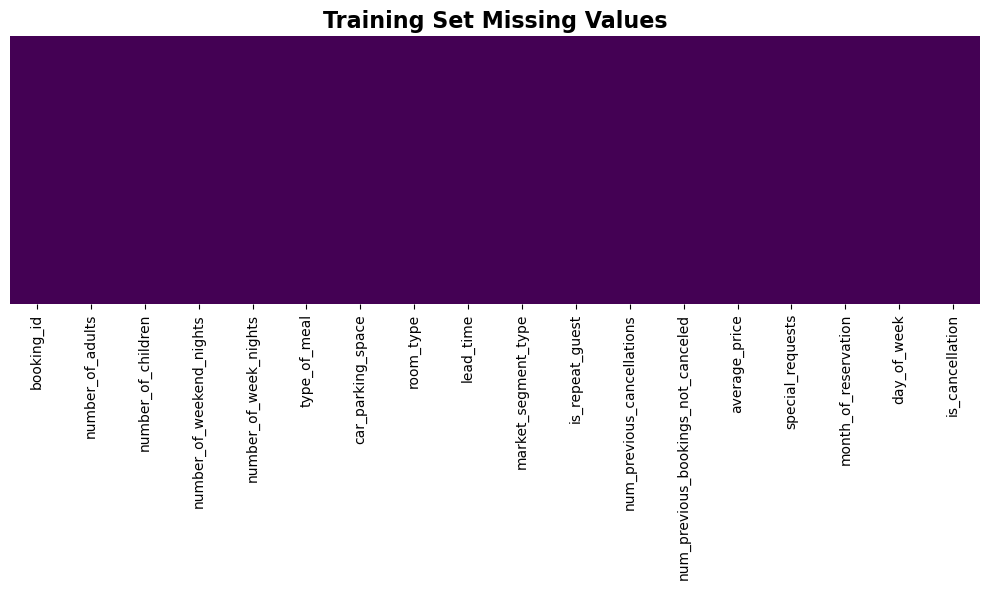

In [29]:
plot_null_val_heatmap(df_train, "Training Set Missing Values", (10,6))

In [30]:
df_train.isna().sum()

booking_id                             0
number_of_adults                       0
number_of_children                     0
number_of_weekend_nights               0
number_of_week_nights                  0
type_of_meal                           0
car_parking_space                      0
room_type                              0
lead_time                              0
market_segment_type                    0
is_repeat_guest                        0
num_previous_cancellations             0
num_previous_bookings_not_canceled     0
average_price                          0
special_requests                       0
month_of_reservation                  20
day_of_week                           20
is_cancellation                        0
dtype: int64

In [31]:
# Replace month_of_reservation and day_of_week missing with the categorical variables' respective modes.
ci = CategoricalImputer(
    imputation_method="frequent",
    variables=["month_of_reservation", "day_of_week"],
)

df_train_imputed = ci.fit_transform(df_train)

In [32]:
df_train_imputed.isna().sum()

booking_id                            0
number_of_adults                      0
number_of_children                    0
number_of_weekend_nights              0
number_of_week_nights                 0
type_of_meal                          0
car_parking_space                     0
room_type                             0
lead_time                             0
market_segment_type                   0
is_repeat_guest                       0
num_previous_cancellations            0
num_previous_bookings_not_canceled    0
average_price                         0
special_requests                      0
month_of_reservation                  0
day_of_week                           0
is_cancellation                       0
dtype: int64

# Feature Engineering

## Engineer Numerical Variables

In general, thre isn't a requirement for normalize dataset for ensemble models, e.g., XGboost and RandomForest. An exception is using L1 and L2 regularization techniques as features need to contribute equally to the penalty terms.
   
Further in the notebook, we will plot a correlation matrix to see if the transformed numerical variables have a stronger correlation than the original (non-transformed) numerical variables.

In [33]:
numerical_vars_to_transform = ["number_of_weekend_nights", "number_of_week_nights", "lead_time", "average_price"]

df_train_numerical_vars_to_transform = df_train_imputed[numerical_vars_to_transform].copy()

# YeoJohnson Transformation
yj_tr = YeoJohnsonTransformer()
df_train_yj = yj_tr.fit_transform(df_train_numerical_vars_to_transform)
df_train_yj.columns = [col + "_yj" for col in df_train_yj.columns]

# Log Transformation
log_tr = LogCpTransformer(C="auto")
df_train_log = log_tr.fit_transform(df_train_numerical_vars_to_transform)
df_train_log.columns = [col + "_log" for col in df_train_log.columns]

# 

## Engineer Categorical Variables

To train our model, we need to transform the categorical variables into numerical variables. This is essential since most machine learning algorithms work with numerical inputs. 

In this dataset, we have the following 5 categorical variables:

- `type_of_meal`
- `room_type`
- `market_segment_type`
- `month_of_reservation`
- `day_of_week`

We will use **one-hot encoding (OHE)** to convert these categorical features into numerical features. Here's how one-hot encoding works:

- If a categorical feature has `k` unique categories, it will be transformed into `k` binary variables.
- Each new binary variable represents the presence or absence of a particular category.

To make these new features easy to identify, we will add the prefix `is_` to the names of the one-hot-encoded features, indicating that they are binary.


In [34]:
# Select which variables for each type of transform = 
# categorical_vars_to_ohe_transform = ["type_of_meal", "room_type", "market_segment_type"]
categorical_vars_to_ohe_transform = ["type_of_meal", "room_type", "market_segment_type", "month_of_reservation", "day_of_week"]

# categorical_vars_to_target_mean_transform = ["month_of_reservation", "day_of_week"]


# One-Hot Encoder
ohe = OneHotEncoder()
df_train_ohe = ohe.fit_transform(df_train_imputed[categorical_vars_to_ohe_transform])
df_train_ohe = convert_columns_to_snake_case(df_train_ohe)
df_train_ohe.columns = ["is_" + col for col in df_train_ohe.columns]
df_train_ohe.head()

# Target-Mean Encoder
# tm = MeanEncoder()
# df_train_tm = tm.fit_transform(df_train_imputed[categorical_vars_to_target_mean_transform], df_train_imputed["is_cancellation"])
# df_train_tm = convert_columns_to_snake_case(df_train_tm)
# df_train_tm.columns = [col + "_tm" for col in df_train_tm.columns]
# df_train_tm.head()

,is_type_of_meal_meal_plan_1,is_type_of_meal_not_selected,is_type_of_meal_meal_plan_2,is_type_of_meal_meal_plan_3,is_room_type_room_type_1,is_room_type_room_type_2,is_room_type_room_type_4,is_room_type_room_type_6,is_room_type_room_type_3,is_room_type_room_type_5,...,is_month_of_reservation_aug,is_month_of_reservation_mar,is_month_of_reservation_feb,is_day_of_week_monday,is_day_of_week_sunday,is_day_of_week_friday,is_day_of_week_wednesday,is_day_of_week_thursday,is_day_of_week_saturday,is_day_of_week_tuesday
3104,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
35123,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7177,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3869,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
16383,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Create "master" engineered training dataset

In [36]:
df_train_master_tr = pd.concat(
    [
        df_train_imputed[numerical_vars_to_transform],
        df_train_yj,
        df_train_log,
        df_train_ohe,
        # df_train_tm,
        df_train_imputed["is_cancellation"],
    ],
    axis=1,
)
        
        
        
df_train_master_tr.head()

,number_of_weekend_nights,number_of_week_nights,lead_time,average_price,number_of_weekend_nights_yj,number_of_week_nights_yj,lead_time_yj,average_price_yj,number_of_weekend_nights_log,number_of_week_nights_log,...,is_month_of_reservation_mar,is_month_of_reservation_feb,is_day_of_week_monday,is_day_of_week_sunday,is_day_of_week_friday,is_day_of_week_wednesday,is_day_of_week_thursday,is_day_of_week_saturday,is_day_of_week_tuesday,is_cancellation
3104,0,2,32,0.0,-0.000000,1.290499,5.810978,0.000000,0.000000,1.098612,...,0,0,1,0,0,0,0,0,0,0
35123,2,3,90,74.8,0.890346,1.700838,8.804822,44.498022,1.098612,1.386294,...,0,0,1,0,0,0,0,0,0,0
7177,1,2,121,90.0,0.605943,1.290499,9.833880,52.114770,0.693147,1.098612,...,0,0,0,1,0,0,0,0,0,1
3869,0,3,151,80.0,-0.000000,1.700838,10.660788,47.128473,0.000000,1.386294,...,0,0,0,0,1,0,0,0,0,0
16383,2,1,31,63.0,0.890346,0.766517,5.732334,38.419820,1.098612,0.693147,...,0,0,1,0,0,0,0,0,0,0


# Correlation between variables

In [ ]:
# compute correlations
corr = df_train_master_tr.corr()

# Exclude duplicate correlations by masking upper-right values
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set background color
sns.set_style(style="white")

# Set up matplotlib figure
fig, ax = plt.subplots(figsize=(20,9))

# Add diverging colormap
cmap = sns.diverging_palette(10, 250, as_cmap=True)

# Draw correlation plot
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax
)

plt.show();

### Correlation Analysis

Let’s focus on the bottom row, which shows the correlation between the predictor variable, `is_cancellation`, and all other features. There are a few key takeaways:

- Applying Yeo-Johnson and logarithmic transformations to the numerical variables does not improve the correlation between the numerical variables and `is_cancellation`. Consequently, these transformations will not be included in the model pipeline.

- There is a strong positive correlation between `lead_time` and `is_cancellation`. This indicates that people who reserve rooms further in advance are more likely to cancel their reservations.

- Three features exhibit a substantial negative correlation with `is_cancellation`:
  - `is_market_segment_type_corporate`: People traveling for business are less likely to cancel.
  - `is_month_of_reservation_dec`: People are less likely to cancel if their arrival date is in December.
  - `is_month_of_reservation_jan`: People are less likely to cancel if their arrival date is in January.


# Validation Pipeline

We will now apply the tranformers that were fitted to the training dataset to the validation dataset. If we would have fit the transformers on the validation set, we would have performed "data leakage".

In [ ]:
# Create master validation set
df_val_master = pd.concat([X_val, y_val], axis=1)

In [ ]:
from typing import List

class ValidationTransformationPipeline():
    def __init__(
        self,
        imputer: CategoricalImputer,
        numerical_vars: List[str],
        categorical_vars_ohe: List[str],
        ohe: OneHotEncoder,
        target_var: str,
    ):  
        self.imputer = imputer
        self.numerical_vars = numerical_vars
        self.categorical_vars_ohe = categorical_vars_ohe
        self.ohe = ohe
        self.target_var = target_var
    
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        # impute the appropriate variables using a trained Imputer
        df_imp = self.imputer.transform(df)
        
        
        # Perform one-hot encoding on the selected variables
        df_ohe = self.ohe.transform(df_imp[self.categorical_vars_ohe])
        
        # rename columns
        df_ohe.columns = ["is_" + col for col in df_ohe.columns]
        
        # create master
        df_master = pd.concat(
            [
                df[self.numerical_vars],
                df_ohe,
                df[target_var],
            ],
            axis=1,
        )
        
        return df_master
                           
    
        

In [ ]:
# transform validation dataset
transformation_pipeline = ValidationTransformationPipeline(
    imputer=ci,
    numerical_vars=numerical_vars_to_transform,
    categorical_vars_ohe=categorical_vars_to_ohe_transform,
    ohe=ohe,
    target_var="is_cancellation",   
)

df_val_master_tr = transformation_pipeline.transform(df_val_master)

# format column names
df_val_master_tr = convert_columns_to_snake_case(df_val_master_tr)

In [ ]:
df_val_master_tr.head()

# Feature Selection

**ASK EMIN:** Should we perform feature selection? How is feature selection typically applied within ML model development?

Feature selection is an important part of model development:
    
1. **Improves model performance** by eliminating irrelevant or redundant features.
2. **Reduces overfitting** by by selecting only the most important featuree that represent the meaningful patterns, lower the risk of overfitting to the training data.
3. **Enhances efficiency** by decreasing the computational complexity because of the lower number of features.

**Cannot use logistic regression because there is multicollinearity among all the one-hot-encoded variables because there are `n` features when there should be `n-1` features for each category that was one-hot encoded.**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Remove numerical features that were transformed.
numerical_vars_transformed = [var for var in df_train_master_tr.columns if "_log" in var or "_yj" in var]
x_train_cols_to_drop = ["is_cancellation"] + numerical_vars_transformed

# create train and validation sests for model build/test
X_train_sel = df_train_master_tr.drop(x_train_cols_to_drop, axis=1)
y_train_sel = df_train_master_tr["is_cancellation"]

# Fit a logistic regression
clsfr = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=800)
clsfr.fit(X_train_sel, y_train_sel)

# Get coefficients
coefficients = pd.DataFrame({
    "Feature": X_train_sel.columns,
    "Coefficient": clsfr.coef_[0]
})

coefficients.sort_values(by="Coefficient", ascending=False, inplace=True)

print("Logistic Regression Coefficients")
print(coefficients)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Caclulate VIF for each feature
vif_data = pd.DataFrame({
    "Feature": X_train_sel.columns,
    "VIF": [variance_inflation_factor(X_train_sel.values, i) for i in range(X_train_sel.shape[1])]
})

print("Variance Inflation Factors (VIF)")
print(vif_data)

# Model Build

`train_test_split` was applied in the beginning of the notebook. Therefore, we only need separate the indepedent and dependent variables to create our `X` and `y` for the training and validation sets, respectively.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

numerical_vars_transformed = [var for var in df_train_master_tr.columns if "_log" in var or "_yj" in var]
x_train_cols_to_drop = ["is_cancellation"] + numerical_vars_transformed

# create train and validation sests for model build/test
X_train = df_train_master_tr.drop(x_train_cols_to_drop, axis=1)
y_train = df_train_master_tr["is_cancellation"]
X_val = df_val_master_tr.drop("is_cancellation", axis=1)
y_val = df_val_master_tr["is_cancellation"]

In [ ]:
from sklearn.dummy import DummyClassifier

model_dummy = DummyClassifier(strategy="most_frequent")
model_dummy.fit(X_train, y_train)
y_pred = model_dummy.predict(X_val)
y_probs = model_dummy.predict_proba(X_val)
auc = roc_auc_score(y_val, y_probs[:, 1])

# print results
print(classification_report(y_val, y_pred))
print("ROC AUC Score: ", auc)

In [ ]:
from sklearn.linear_model import LogisticRegression

clsfr = LogisticRegression(
    penalty="l2", # Ridge
    C=1.0,
    solver="lbfgs",
    max_iter=800,
)
clsfr.fit(X_train, y_train)
y_pred = clsfr.predict(X_val)
y_probs = clsfr.predict_proba(X_val)
auc = roc_auc_score(y_val, y_probs[:, 1])

# print results
print(classification_report(y_val, y_pred))
print("ROC AUC Score: ", auc)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clsfr = RandomForestClassifier(
    n_estimators=300, 
    max_depth=5,
    max_features="sqrt",
    min_samples_split=5,
)
clsfr.fit(X_train, y_train)
y_pred = clsfr.predict(X_val)
y_probs = clsfr.predict_proba(X_val)
auc = roc_auc_score(y_val, y_probs[:, 1])

# print results
print(classification_report(y_val, y_pred))
print("ROC AUC Score: ", auc)

In [ ]:
from xgboost import XGBClassifier

clsfr = XGBClassifier(
    n_estimators=300, 
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
)
clsfr.fit(X_train, y_train)
y_pred = clsfr.predict(X_val)
y_probs = clsfr.predict_proba(X_val)
auc = roc_auc_score(y_val, y_probs[:, 1])

# print results
print(classification_report(y_val, y_pred))
print("ROC AUC Score: ", auc)

# Hyperparamter Optimization

**ASK EMIN:** Why is Random Forest returning a better result than XGBoost after the RandomizedSearchCV? Meanwhile, XGBoost perfoms better above.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

def best_model_selection(X_train, y_train, X_val, y_val, models, param_grid):
    models_with_performance = pd.DataFrame()
    auc_scores = []
    f1_scores = []
    best_params = []
    
    for idx in range(len(models)):
        model = models[idx]
        random_cv = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid[idx],
            cv=5,
            verbose=10,
            random_state=3,
            n_jobs=-1,
            scoring="roc_auc_score",
        
        )
        random_cv.fit(X_train, y_train)
        y_pred = random_cv.predict(X_val)
        y_probs = random_cv.predict_proba(X_val)
        
        # Calculate performance
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_probs[:,1])
        
        # Collect results
        best_params.append(random_cv.best_params_)
        f1_scores.append(f1)
        auc_scores.append(auc)
        
    
    # add values to results
    models_with_performance["models"] = models
    models_with_performance["best_params"] = best_params
    models_with_performance["auc_score"] = auc_scores
    models_with_performance["f1_score"] = f1_scores
    
    return models_with_performance
        

In [ ]:
model_rf = RandomForestClassifier()
random_grid_rf = {'n_estimators': [int(x) for x in np.linspace(start = 0, stop = 100, num = 50)],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [int(x) for x in np.linspace(0, 50, num = 10)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False]}

model_xgb = XGBClassifier()
random_grid_xgboost = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                       'min_child_weight': np.arange(0.0001, 0.5, 0.001),
                       'gamma': np.arange(0.0,40.0,0.005),
                       'learning_rate': np.arange(0.0005,0.3,0.0005),
                       'subsample': np.arange(0.01,1.0,0.01),
                       'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
                       'colsample_bytree': np.arange(0.1,1.0,0.01)}
models = list()
models.append(model_rf)
models.append(model_xgb)

params = dict()
params[0] = random_grid_rf
params[1] = random_grid_xgboost


best_model_selection(X_train, y_train, X_val, y_val, models, params)

# Pipeline

In [ ]:
VARIABLE_RENAME_MAP = {
    "repeated" : "is_repeat_guest",
    "pc": "num_previous_cancellations",
    "pnot_c": "num_previous_bookings_not_canceled",
}

MONTH_ABBREVIATION_MAP = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}


MONTH_ORDER = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

DAY_OF_WEEK_ORDER = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

BOOKING_MAP = {
    "Not_Canceled": 0,
    "Canceled": 1,
}

In [ ]:
from sklearn.base import TransformerMixin
from typing import Dict, Tuple

class NoVacancyDataProcessing(TransformerMixin):
    def __init__(
        self,
        variable_rename: Dict[str, str],
        month_abbreviation: Dict[int, str],
        booking_map: Dict[str, int],
        target_var: str,
    ):
        super().__init__()

        self.variable_rename = variable_rename
        self.month_abbreviation = month_abbreviation
        self.booking_map = booking_map

    
    def fit(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        return self
    
    
    def transform(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        X_tr = X.copy()
        
        # Standardize column name text
        X_tr = self._convert_columns_to_snake_case(X_tr)
        
        # Extract month and day of week features from "date of reservation"
        X_tr["date_of_reservation"] = pd.to_datetime(X_tr["date_of_reservation"], format='%m/%d/%Y', errors='coerce').dt.date 
        X_tr["month_of_reservation"] = pd.to_datetime(X_tr["date_of_reservation"], errors="coerce").dt.month
        X_tr["month_of_reservation"] = X_tr["month_of_reservation"].map(MONTH_ABBREVIATION_MAP)
        X_tr["day_of_week"] = pd.to_datetime(X_tr["date_of_reservation"]).dt.day_name()
        
        # transform predictor
        y_tr = y.map(booking_map)
        
        return X_try, y_tr
    
    
    def _to_snake_case(self, name: str) -> str:
        # Preserve existing underscores and replace spaces or special characters with underscores
        name = re.sub(r'[^\w\s]', '', name)  # Remove special characters except underscores
        name = re.sub(r'(?<=[a-z])(?=[A-Z])', '_', name)  # Handle camelCase to snake_case
        name = re.sub(r'[\s]+', '_', name)  # Replace spaces with underscores
        return name.lower()
    
    
    def _convert_columns_to_snake_case(self, df: pd.DataFrame) -> pd.DataFrame:
        # Transform column names
        new_columns = [to_snake_case(col).replace('__', '_') for col in df.columns]
        df.columns = new_columns
        return df
